In [1]:
using Plots

In [2]:
function ntrp3h(tint, t, y, yp, tnew, ynew, ypnew)
    # Hermite extrapolation
    h     = tnew - t;
    s     = (tint - t)/h;
    s2    = s * s;
    s3    = s * s2;
    slope = (ynew - y)/h;
    c     = 3*slope - 2*yp - ypnew;
    d     = yp + ypnew - 2*slope;
    
    return y + (h*d*s3 + h*c*s2 + h*yp*s);           
end

function int_simpson(h, y_begin, y_end, y_half)
    # Simpson's method
    return h/6*(y_begin + 4*y_half + y_end);
end

function MatrixA(a, step)
    A = zeros(step);
    if step == 0
        A = 0;
    elseif step == 1
        A = a;
    elseif step == 2
        A = [a * (1 - a * 1/2); 1/2 * a^2];
    elseif step == 3
        A = [a * (1 - a * 1/2); 1/2 * a^2; 0];
    elseif step == 4
        sqrA = a^2;
        A = [a * (1 + a * (-3/2 + a * 2/3)); 0; 
                sqrA * (2 - a * 4/3); 
                sqrA * (-1/2 + a * 2/3)];
    elseif step == 5
        sqrA = a^2;
        A = [a * (1 + a * (-3/2 + a * 2/3)); 0;
                sqrA * (1 - a * 4/3); 
                sqrA * (-1/2 + a * 2/3); sqrA];
    end
    return A;
end

function b4(a)
    x = zeros(6,1);
    sqrA = a^2;
    x[1,1] = a * (1 + a * (-3/2 + a * 2/3));
    x[2,1] = 0;
    x[3,1] = 0;
    x[4,1] = 0;
    x[5,1] = sqrA * (2 + a * -4/3);
    x[6,1] = sqrA * (-1/2 + a * 2/3);
    return x;
end

function find_z()
    #println(d_ti);
end

function ide_delay_rk(idefun,delays,Core,delays_int,history,tspan,step)
    #global d_ti, nz, t0, z, ti, t, h, y, K, htry;
    #  idefun - right-hand side function
    #    Core - Kernel (integrated function)
    #  delays - delays function (lower integration limit)
    # History - history function
    #   tspan - solution interval
    #    step - step-size
      
    t0   = tspan[1];    # t begin
    tf   = tspan[2];    # t end
    y0   = history(t0); # initial solution
    neq  = length(y0);  # number of equations
    htry = step;        # constant mesh step-size
    h    = htry;        # current step-size (for the last step)
    
    d_t0 = delays(t0,y0);
    nz   = length(d_t0);
    #==============================================================#
    # VIDE Runge-Kutta Bel'tyukov-type of Order 4
#     A = [0 1/2   0  0
#          0   0 1/2  0 
#          0   0   0  1     
#          0   0   0  0 ];
    
#     b = [1/6; 1/3; 1/3; 1/6];
#     s = length(b);
#     c = [0 1/2 1/2 1];
#     d = [1/2; 1/2; 1];
    
    # VIDE Runge-Kutta Tavernini
    A = [0 1 3/8  1/2  5/24  1/6
         0 0 1/8  1/2     0    0
         0 0   0    0   1/3 -1/3 
         0 0   0    0 -1/24  1/6
         0 0   0    0     0    1
         0 0   0    0     0    0];
    
    b = [1/6; 0; 0; 0; 2/3; 1/6];
    s = length(b);
    c = [0 1 1/2 1 1/2 1];
    d = [1/2; 1/2; 1/2; 1/2; 1];
    #==============================================================#
    nint = length(delays_int(t0));
    # Calculate integral (F) in history
    F      = zeros(nint);
    F_1    = zeros(nint);
    F_half = zeros(nint);
    
    # Piece from delays(t0) to the next mesh point
    # tj, tj_half, tj_1, Core_tj, Core_tj_1, Core_tj_h are always needed
    # to use Simpson's Method for numerical approximations of integrals
    tj      = delays_int(t0);             # Begin
    for ij = 1:nint
        step    = trunc(Int,(t0 - tj[ij])/h); # The number of memorized 
                                          # intervals of history
        tj_1    = t0 - step*h;            # End
        tj_half = (tj[ij]+tj_1)/2;            # Half segment

        # Calculate Kernel values at the nodes
        Core_tj   = Core(t0, tj[ij], history(tj[ij]));
        Core_tj_1 = Core(t0, tj_1, history(tj_1));
        Core_tj_h = Core(t0, tj_half, history(tj_half));

        # Simpson's method
        F[ij]   = F[ij] + int_simpson(tj_1-tj[ij], Core_tj[ij], Core_tj_1[ij], Core_tj_h[ij]);

        # Main integral over the mesh points
        Core_tj = Core_tj_1;
        for j = step-1:-1:0
            tj_1      = t0 - j*h;
            tj_half   = tj_1 - h/2;

            # Calculate Kernel values at the nodes
            Core_tj_h = Core(t0, tj_half, history(tj_half));
            Core_tj_1 = Core(t0, tj_1, history(tj_1));

            # Simpson's method
            F[ij]         = F[ij] + int_simpson(h, Core_tj[ij], Core_tj_1[ij], Core_tj_h[ij]);

            # Kernel of tj_1 is equal to tj of the next step
            Core_tj   = Core_tj_1;
        end
    end
    #println(F);
    #F = ones(neq).*(exp(t0)-exp(delays(t0)));
    #F = ones(neq).*(exp(t0*(1-t0))/(1-t0)-exp(delays(t0)*(1-t0))/(1-t0));
    #==============================================================#
    # Initialization | First Step | Y | K
    t      = t0; 
    y      = zeros(neq,1);
    y[:,1] = ones(neq).*y0;
    k      = 1;  # step
    
    z = zeros(neq,nz);
    for j = 1 : nz
        z[:,j] = ones(neq).*history(d_t0[j]);
    end
    
    Y        = zeros(neq,s);
    K        = zeros(neq,s,1);
    
    #println(idefun(t[k], y[:,1], z, F))
    
    K[:,1,k] = ones(neq).*idefun(t[k], y[:,1], z, F);
    Core_di  = zeros(nint,s);
    #==============================================================#
    
    while t[k] < tf
        #==========================================================#
        # Last step
        if t[k] + h > tf
            h = tf - t[k];
        end
        #==========================================================#
        Z      = zeros(nint,s);
        Y[:,1] = y[:,k];

        # Runge-Kutta steps
        for i = 2 : s
            ti = t[k] + c[i]*h;
            #======================================================#
            # Calculate integral (F)
            if i == 2 || i == 3 # c[3] = c[2] so the same F value is used
                F = zeros(nint);
                
                dtk_begin = delays_int(ti); # lower integration limit
                for ij = 1:nint
                    if dtk_begin[ij] < t0
                        #==============================================#
                        # Integral begins in the history

                        # Step of delays(ti) in the history
                        step = trunc(Int,(t0 - dtk_begin[ij])/h); 

                        # Add piece from dtk_begin to the next mesh point in the history
                        tj        = dtk_begin[ij];
                        tj_1      = t0-step*htry;
                        tj_half   = (tj+tj_1)/2;

                        # Calculate Kernel values at the nodes
                        Core_tj   = Core(ti, tj, history(tj));
                        Core_tj_1 = Core(ti, tj_1, history(tj_1));
                        Core_tj_h = Core(ti, tj_half, history(tj_half));

                        # Simpson's method
                        F[ij] = F[ij] + int_simpson(tj_1-tj, Core_tj[ij], Core_tj_1[ij], Core_tj_h[ij]);

                        # Main integral in the history
                        Core_tj = Core_tj_1;
                        for j = step-1:-1:0
                            tj_1      = t0 - j*htry;
                            tj_half   = tj_1 - htry/2;

                            # Calculate Kernel values at the nodes
                            Core_tj_1 = Core(ti, tj_1, history(tj_1));
                            Core_tj_h = Core(ti, tj_half, history(tj_half));

                            # Simpson's method
                            F[ij] = F[ij] + int_simpson(htry, Core_tj[ij], Core_tj_1[ij], Core_tj_h[ij]);

                            # Kernel of tj_1 is equal to tj of the next step 
                            Core_tj   = Core_tj_1;
                        end

                        # Add integral in the solution to t(k)
                        for j = 2:k
                            tj_half   = t[j] - htry/2;
                            y_half    = ntrp3h(tj_half, t[j-1], y[:,j-1], K[:,1,j-1],
                                                        t[j], y[:,j], K[:,1,j]);

                            # Calculate Kernel values at the nodes
                            if neq == 1
                                Core_tj_h = Core(ti, tj_half, y_half[1]);
                                Core_tj_1 = Core(ti, t[j], y[1,j]);
                            else
                                Core_tj_h = Core(ti, tj_half, y_half);
                                Core_tj_1 = Core(ti, t[j], y[:,j]);
                            end

                            # Simpson's method
                            F[ij] = F[ij] + int_simpson(htry,Core_tj[ij],Core_tj_1[ij],Core_tj_h[ij]);

                            # Kernel of tj_1 is equal to tj of the next step 
                            Core_tj   = Core_tj_1;
                        end
                        #==============================================#
                    else
                        #==============================================#
                        # Integral only over the solution

                        # Step of delays(ti) in the solution
                        step      = trunc(Int,(dtk_begin[ij]-t0)/htry + 1);

                        # Add piece from dtk_begin to the mesh point in the solution
                        tj_half   = (t[step+1] + dtk_begin[ij])/2;

                        y_begin   = ntrp3h(dtk_begin[ij], t[step], y[:,step], K[:,1,step],
                                                  t[step+1], y[:,step+1], K[:,1,step+1]);
                        y_begin_h = ntrp3h(tj_half, t[step], y[:,step], K[:,1,step],
                                                t[step+1], y[:,step+1], K[:,1,step+1]);

                        # Calculate Kernel values at the nodes
                        if neq == 1
                            Core_tj   = Core(ti, dtk_begin[ij], y_begin[1]);
                            Core_tj_1 = Core(ti, t[step+1], y[1,step+1]);
                            Core_tj_h = Core(ti, tj_half, y_begin_h[1]);
                        else
                            Core_tj   = Core(ti, dtk_begin[ij], y_begin);
                            Core_tj_1 = Core(ti, t[step+1], y[:,step+1]);
                            Core_tj_h = Core(ti, tj_half, y_begin_h);
                        end

                        # Simpson's method
                        F[ij] = F[ij] + int_simpson(t[step+1]-dtk_begin[ij], Core_tj[ij],
                                                       Core_tj_1[ij], Core_tj_h[ij]);

                        # Main integral to t(k)
                        Core_tj = Core_tj_1;
                        for j = step+2:k
                            tj_half   = t[j] - htry/2;
                            y_half    = ntrp3h(tj_half, t[j-1], y[:,j-1], K[:,1,j-1],
                                                        t[j], y[:,j], K[:,1,j]);

                            # Calculate Kernel values at the nodes
                            if neq == 1
                                Core_tj_h = Core(ti, tj_half, y_half[1]);
                                Core_tj_1 = Core(ti, t[j], y[1,j]);
                            else
                                Core_tj_h = Core(ti, tj_half, y_half);
                                Core_tj_1 = Core(ti, t[j], y[:,j]);
                            end

                            # Simpson's method
                            F[ij] = F[ij] + int_simpson(htry, Core_tj[ij], Core_tj_1[ij], Core_tj_h[ij]);

                            # Kernel of tj_1 is equal to tj of the next step 
                            Core_tj   = Core_tj_1;
                        end
                        #==============================================#
                    end
                end
                if i == 2
                    F_1 = F;
                else
                    F_half = F;
                end
            end
            if i == 4 || i == 6
                F = F_1;
            elseif i == 5
                F = F_half;
            end
            #F = ones(neq).*(exp(t[k])-exp(delays(ti)))
            #F = ones(neq).*(exp(t[k]*(1-ti))/(1-ti)-exp(delays(ti)*(1-ti))/(1-ti));
            #======================================================#
            # Y2-S
            Y[:,i] = y[:,k] + h * (K[:,1:i-1,k] * A[1:i-1,i]);
            
            # Z2-S
            if nint == 1
                Core_di[1,i-1] = Core(t[k]+d[i-1]*h, t[k]+c[i-1]*h, Y[1,i-1]);
            else
                Core_di[:,i-1] = Core(t[k]+d[i-1]*h, t[k]+c[i-1]*h, Y[:,i-1]);
            end
            Z[:,i]         = h * (Core_di[:,1:i-1] * A[1:i-1,i]);
            
            #======================================================#
            #Finding delays Z
            d_ti = delays(ti,Y[:,i]);
            
            for kz = 1 : nz
                if d_ti[kz] < t0
                    z[:,kz] = ones(neq).*history(d_ti[kz]);
                elseif ti < d_ti[kz]
                    # wrong overlapping
                    error("Delays went ahead.");
                elseif t[k] - d_ti[kz] <= 0
                    # overlapping
                    teta = (d_ti[kz] - t[k]) / h;
                    z[:,kz] = y[:,k] + h * (K[:,1:i-1,k]*MatrixA(teta,i-1));
                else
                    # find t
                    #============Binary search algorithm===========#
                    tcur = d_ti[kz];
                    iz = 1;
                    jz = length(t);
                    nstep = trunc(Int,jz/2);

                    while (((t[nstep+1] < tcur || t[nstep] > tcur)) && iz < jz)
                        if tcur > t[nstep]
                            iz = nstep + 1;
                        else
                            jz = nstep - 1;
                        end
                        nstep = trunc(Int,(iz+jz)/2);
                    end
                    
                    # find y_t
                    theta = (tcur - t[nstep])/htry;
                    z[:,kz] = y[:,nstep] + htry * (K[:,:,nstep] * b4(theta));
                end
            end
            #======================================================#
            # K2-S
            K[:, i, k] = ones(neq).*idefun(ti, Y[:,i], z, F+Z[:,i]);
        end
        #==========================================================#
        # Final approximation of RK Method
        t = [t; t[k] + h];
        y = [y y[:,k] + h * ( K[:,:,k] * b )];
        #==========================================================#
        # Calculate K(1) for next step
        # Hermite extrapolation for K(1,k+1)
        y_k_half     = 3/4*y[:,k] + 1/4*y[:,k+1] + h/4*K[:,1,k];
        if neq == 1
            Core_tj      = Core(t[k+1], t[k], y[1,k]);
            Core_tk_half = Core(t[k+1], t[k]+h/2, y_k_half[1]);
            Core_tk      = Core(t[k+1], t[k+1], y[1,k+1]);
        else
            Core_tj      = Core(t[k+1], t[k], y[:,k]);
            Core_tk_half = Core(t[k+1], t[k]+h/2, y_k_half);
            Core_tk      = Core(t[k+1], t[k+1], y[:,k+1]);
        end
        
        F  = F + ones(nint).*int_simpson(h,Core_tj,Core_tk,Core_tk_half);
        K1 = zeros(neq,s,1);
        K  = cat(K, K1, dims=3);
        
        #F = ones(neq).*(exp(t[k+1])-exp(delays(t[k+1])));
        #F = exp(t[k+1]*(1-t[k+1]))/(1-t[k+1])-exp(delays(t[k+1])*(1-t[k+1]))/(1-t[k+1]);
        
        K[:,1,k+1] = ones(neq).*idefun(t[k+1], y[:,k+1], z, F);
        
        k = k + 1;
    end
    return t, y';
end

ide_delay_rk (generic function with 1 method)

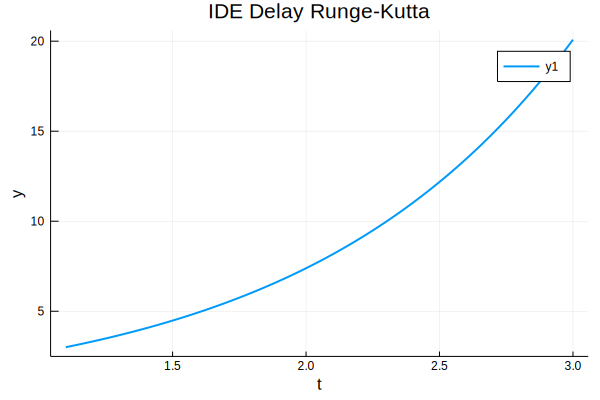

In [3]:
# Example 1
tspan = [1.1 3];
idefun(t,y,z,int) = ((t-1)*exp(t*t)*int)/(exp(-1)*y[1]-1);
K(t,s,y)          = y*exp(-s*t);
delays(t,y)       = t-1; # delays of z
delays_int(t)     = t-1; # delays of integrals
history(t)        = exp(t);

sol = ide_delay_rk(idefun,delays,K,delays_int,history,tspan,1e-2);

# Output vector of times t
# Output vector of solutions y
#print(sol[1])
#print(sol[2])

# create a line plot
plot(sol, linewidth=2, xlabel="t", ylabel="y", title="IDE Delay Runge-Kutta")

4.000350271101473


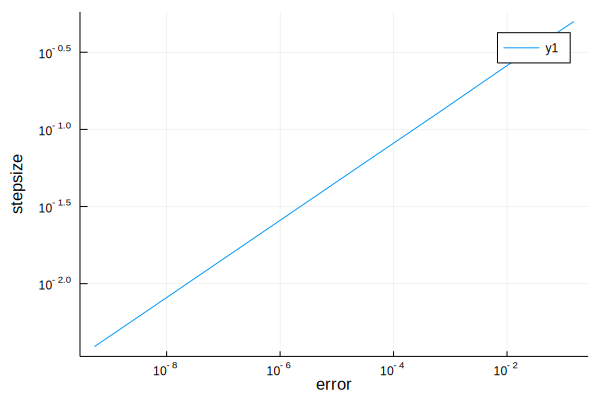

In [4]:
# Check 4-order of Example 1
function fun1(t)
    return exp(t);
end

tspan = [1.1 3];
true_sol = fun1(tspan[end])

idefun(t,y,z,int) = ((t-1)*exp(t*t)*int)/(exp(-1)*y[1]-1);
K(t,s,y)          = y*exp(-s*t);
delays(t,y)       = t-1; #not needed
delays_int(t)     = t-1;
history(t)        = exp(t);

n = 8;
err = zeros(n);
nsteps = zeros(n);

for steppow = 1:n
    stepsize = (2.0)^(-steppow);
    
    sol = ide_delay_rk(idefun,delays,K,delays_int,history,tspan,stepsize);

    err[steppow] = abs(true_sol - sol[2][end]);
    nsteps[steppow] = stepsize;
end

println((log10(err[end-1])-log10(err[end]))/(log10((2.0)^(-n+1))-log10((2.0)^(-n))))

plot(err, nsteps, xaxis=:log10, yaxis=:log10, xlabel="error", ylabel="stepsize")

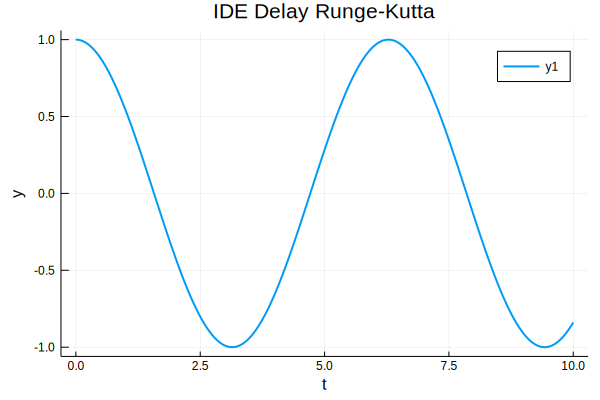

In [5]:
# Example 2 with delays
tspan = [0 10];
idefun(t,y,z,int) = (1+exp(-pi/2))*y-exp(-pi/2)*z-2*exp(-2*t)*int;
K(t,s,y)          = y*exp(t+s); 
delays(t,y)       = t-pi/2;
delays_int(t)     = t-pi/2;
history(t)        = cos(t);

sol = ide_delay_rk(idefun,delays,K,delays_int,history,tspan,1e-2);

# Output vector of times t
# Output vector of solutions y
#print(sol[1])
#print(sol[2])

# create a line plot
plot(sol, linewidth=2, xlabel="t", ylabel="y", title="IDE Delay Runge-Kutta")

3.9942597131307522


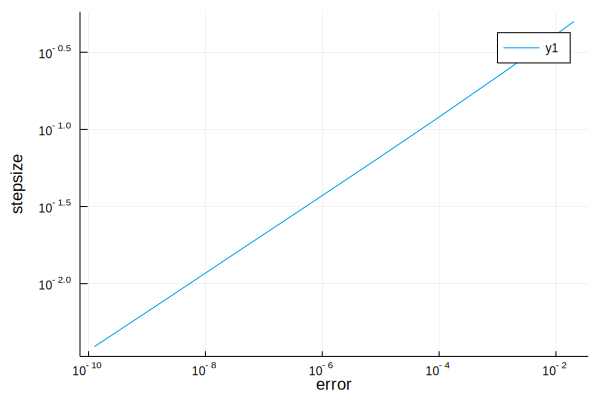

In [6]:
# Check 4-order of Example 2 
function fun1(t)
    return cos(t);
end

tspan = [0 10];
true_sol = fun1(tspan[end])

idefun(t,y,z,int) = (1+exp(-pi/2))*y-exp(-pi/2)*z-2*exp(-2*t)*int;
K(t,s,y)          = y*exp(t+s); 
delays(t,y)       = t-pi/2;
delays_int(t)     = t-pi/2;
history(t)        = cos(t);

n = 8;
err = zeros(n);
nsteps = zeros(n);

for steppow = 1:n
    stepsize = (2.0)^(-steppow);
    
    sol = ide_delay_rk(idefun,delays,K,delays_int,history,tspan,stepsize);

    err[steppow] = abs(true_sol - sol[2][end]);
    nsteps[steppow] = stepsize;
end

println((log10(err[end-1])-log10(err[end]))/(log10((2.0)^(-n+1))-log10((2.0)^(-n))))

plot(err, nsteps, xaxis=:log10, yaxis=:log10, xlabel="error", ylabel="stepsize")

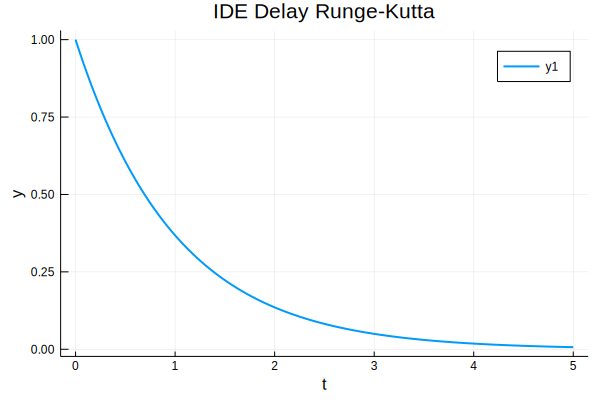

In [7]:
# Example 3 with delays and overlapping
tspan = [0 5];
idefun(t,y,z,int) = -y.^2-t*exp(t^2)*z^4*int;
K(t,s,y)          = y*exp(s-s*t); 
delays(t,y)       = t/2;
delays_int(t)     = t-1;
history(t)        = exp(-t);

sol = ide_delay_rk(idefun,delays,K,delays_int,history,tspan,1e-2);

# Output vector of times t
# Output vector of solutions y
#print(sol[1])
#print(sol[2])

# create a line plot
plot(sol, linewidth=2, xlabel="t", ylabel="y", title="IDE Delay Runge-Kutta")

3.994896598918342


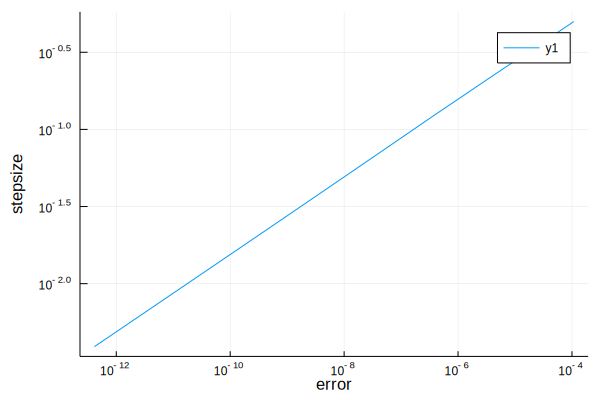

In [8]:
# Check 4-order of Example 3 
function fun1(t)
    return exp(-t);
end

tspan = [0 5];
true_sol = fun1(tspan[end])

idefun(t,y,z,int) = -y.^2-t*exp(t^2)*z^4*int;
K(t,s,y)          = y*exp(s-s*t); 
delays(t,y)       = t/2;
delays_int(t)     = t-1;
history(t)        = exp(-t);

n = 8;
err = zeros(n);
nsteps = zeros(n);

for steppow = 1:n
    stepsize = (2.0)^(-steppow);
    
    sol = ide_delay_rk(idefun,delays,K,delays_int,history,tspan,stepsize);

    err[steppow] = abs(true_sol - sol[2][end]);
    nsteps[steppow] = stepsize;
end

println((log10(err[end-1])-log10(err[end]))/(log10((2.0)^(-n+1))-log10((2.0)^(-n))))

plot(err, nsteps, xaxis=:log10, yaxis=:log10, xlabel="error", ylabel="stepsize")

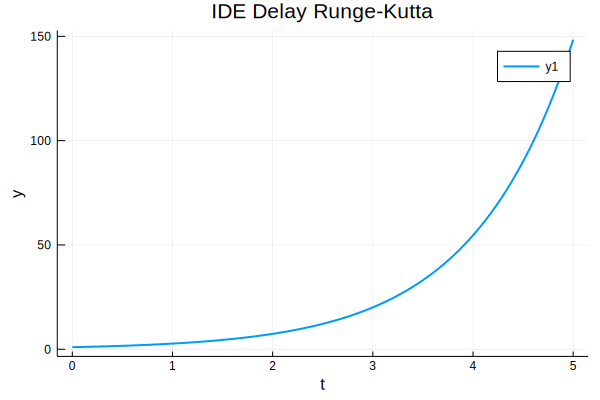

In [9]:
# Example 4 of system with 3 equations and 2 integrals
tspan = [0 5];
idefun(t,y,z,int) = exp(1)-exp(t^2)/(z[1]^2)*(int[1]-exp(-2*t)*int[2])*(t-1);
K(t,s,y)          = [ y*exp(-s*t);
                      y*exp(t*(2-s))];
delays(t,y)       = t-1;
delays_int(t)     = [ t-1;
                      t-2 ];
history(t)        = exp(t);

sol = ide_delay_rk(idefun,delays,K,delays_int,history,tspan,1e-2);

# Output vector of times t
# Output vector of solutions y
#print(sol[1])
#print(sol[2])

# create a line plot
plot(sol, linewidth=2, xlabel="t", ylabel="y", title="IDE Delay Runge-Kutta")

3.992936102301642


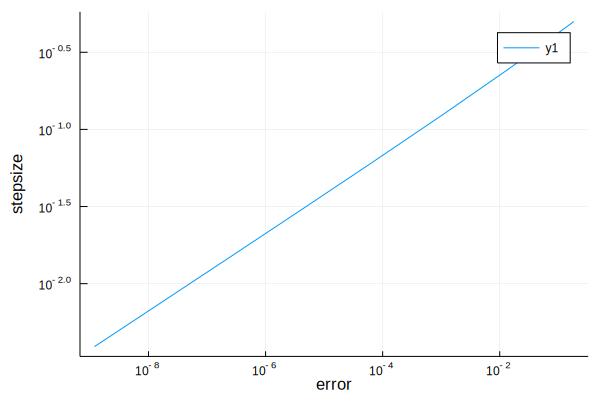

In [10]:
# Check 4-order of Example 4 
function fun1(t)
    return exp(t);
end

tspan = [0 5];
true_sol = fun1(tspan[end])

idefun(t,y,z,int) = exp(1)-exp(t^2)/(z[1]^2)*(int[1]-exp(-2*t)*int[2])*(t-1);
K(t,s,y)          = [ y*exp(-s*t);
                      y*exp(t*(2-s))];
delays(t,y)       = t-1;
delays_int(t)     = [ t-1;
                      t-2 ];
history(t)        = exp(t);

n = 8;
err = zeros(n);
nsteps = zeros(n);

for steppow = 1:n
    stepsize = (2.0)^(-steppow);
    
    sol = ide_delay_rk(idefun,delays,K,delays_int,history,tspan,stepsize);

    err[steppow] = abs(true_sol - sol[2][end]);
    nsteps[steppow] = stepsize;
end

println((log10(err[end-1])-log10(err[end]))/(log10((2.0)^(-n+1))-log10((2.0)^(-n))))

plot(err, nsteps, xaxis=:log10, yaxis=:log10, xlabel="error", ylabel="stepsize")

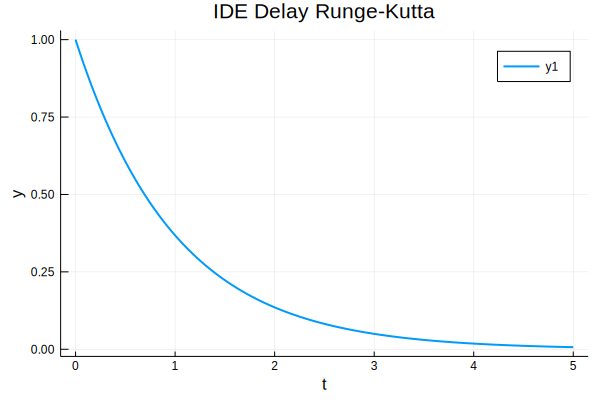

In [11]:
# Example 5 with 2 discrete delays
tspan = [0 5];
idefun(t,y,z,int) = -z[1]^((t+1)/2) * z[2] * y.^2 * (1+exp(t^2)*t*int[1]) / exp(1/2);
K(t,s,y)          = y*exp(s-s*t);
delays(t,y)       = [ (log(y[1]))^2 / (t+1) - 1/2;
                      (t-1) / 4 ];
delays_int(t)     = t/2-1;
history(t)        = exp(-t);

sol = ide_delay_rk(idefun,delays,K,delays_int,history,tspan,1e-2);

# Output vector of times t
# Output vector of solutions y
#print(sol[1])
#print(sol[2])

# create a line plot
plot(sol, linewidth=2, xlabel="t", ylabel="y", title="IDE Delay Runge-Kutta")

4.034954918091005


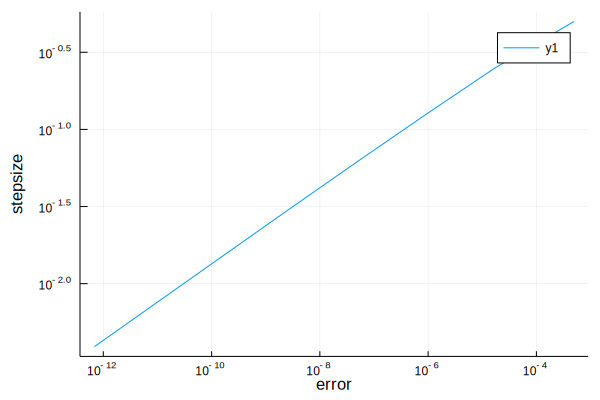

In [12]:
# Check 4-order of Example 5
function fun1(t)
    return exp(-t);
end

tspan = [0 5];
true_sol = fun1(tspan[end])

idefun(t,y,z,int) = -z[1]^((t+1)/2) * z[2] * y.^2 * (1+exp(t^2)*t*int[1]) / exp(1/2);
K(t,s,y)          = y*exp(s-s*t);
delays(t,y)       = [ (log(y[1]))^2 / (t+1) - 1/2;
                      (t-1) / 4 ];
delays_int(t)     = t/2-1;
history(t)        = exp(-t);

n = 8;
err = zeros(n);
nsteps = zeros(n);

for steppow = 1:n
    stepsize = (2.0)^(-steppow);
    
    sol = ide_delay_rk(idefun,delays,K,delays_int,history,tspan,stepsize);

    err[steppow] = abs(true_sol - sol[2][end]);
    nsteps[steppow] = stepsize;
end

println((log10(err[end-1])-log10(err[end]))/(log10((2.0)^(-n+1))-log10((2.0)^(-n))))

plot(err, nsteps, xaxis=:log10, yaxis=:log10, xlabel="error", ylabel="stepsize")

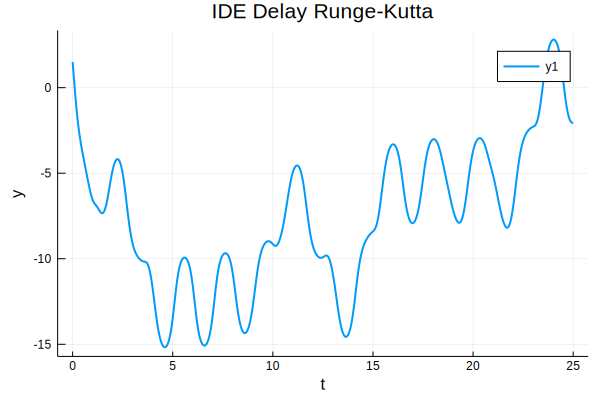

In [13]:
tspan = [0 25];
idefun(t,y,z,int) = -15*int;
K(t,s,y)          = sin(y); 
delays(t,y)       = t-1;
delays_int(t)     = t-1;
history(t)        = 1.5;

sol = ide_delay_rk(idefun,delays,K,delays_int,history,tspan,1e-2);

# Output vector of times t
# Output vector of solutions y
#print(sol[1])
#print(sol[2])

# create a line plot
plot(sol, linewidth=2, xlabel="t", ylabel="y", title="IDE Delay Runge-Kutta")

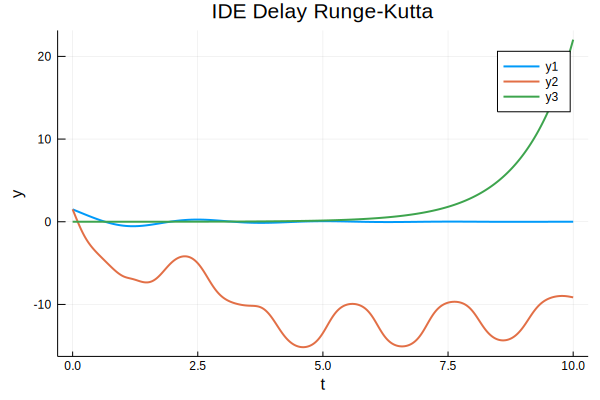

In [14]:
# Example of system with 3 equations and 2 integrals
tspan = [0 10];
idefun(t,y,z,int) = [ -2.5*int[1];
                      -15*int[2];
                      0.001*exp(t)];
K(t,s,y)          = [ sin(y[1]);
                      sin(y[2])];
delays(t,y)       = t-1;
delays_int(t)     = [ t-1;
                      t-1 ];
history(t)        = [ 1.5;
                      1.5;
                      0.001*exp(t)];

sol = ide_delay_rk(idefun,delays,K,delays_int,history,tspan,1e-2);

# Output vector of times t
# Output vector of solutions y
#print(sol[1])
#print(sol[2])

# create a line plot
plot(sol, linewidth=2, xlabel="t", ylabel="y", title="IDE Delay Runge-Kutta")

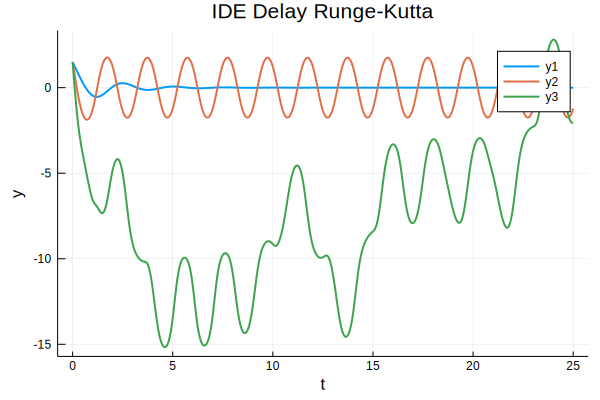

In [15]:
tspan = [0 25];
idefun(t,y,z,int) = [ -2.5*int[1];
                      -7.5*int[2];
                       -15*int[3] ];
K(t,s,y)        = [ sin(y[1]);
                    sin(y[2]);
                    sin(y[3]) ];
delays(t,y)     = t-1;
delays_int(t)   = [ t-1;
                    t-1;
                    t-1 ];
    
history(t)      = [ 1.5;
                    1.5;
                    1.5 ];

sol = ide_delay_rk(idefun,delays,K,delays_int,history,tspan,1e-2);

# Output vector of times t
# Output vector of solutions y
#print(sol[1])
#print(sol[2])

# create a line plot
plot(sol, linewidth=2, xlabel="t", ylabel="y", title="IDE Delay Runge-Kutta")